In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from tqdm  import tqdm, trange

from glob import glob
from skimage import io
from addict import Dict
from IPython import display
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torchvision.transforms.functional as f  
from torchsummary import summary



import warnings
warnings.filterwarnings("ignore")

from model import EarlyStopping
from model.dataset import Dataset
from model.train import train
from model.test import test
from model.network import Net 
from model.function import seed_torch


seed_torch(seed=42)
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

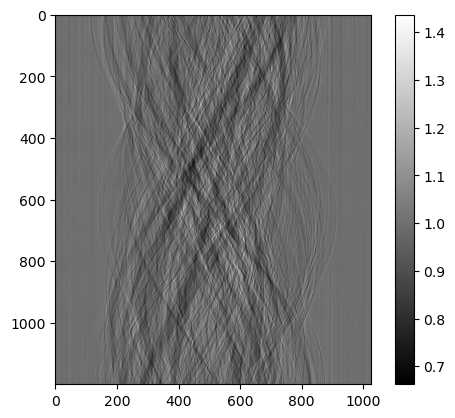

In [2]:
img=io.imread("/home/zhengmao/hbtask/SHARP/data/bamboo_data/sino/sino_001001.tif")
plt.imshow(img,cmap='gray')
plt.colorbar()

In [3]:
args = Dict(device="cpu", batch_size=2, init_lr=0.001, epochs=500,patch_size= None)
datadir = '/home/zhengmao/hbtask/SHARP/data/bamboo_data/'
train_data = Dataset(datadir=datadir, sample=2, device=args.device,patch_size=args.patch_size,nums_projects=1200)
valid_data = Dataset(datadir=datadir, device=args.device,nums_projects=1200)
train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)

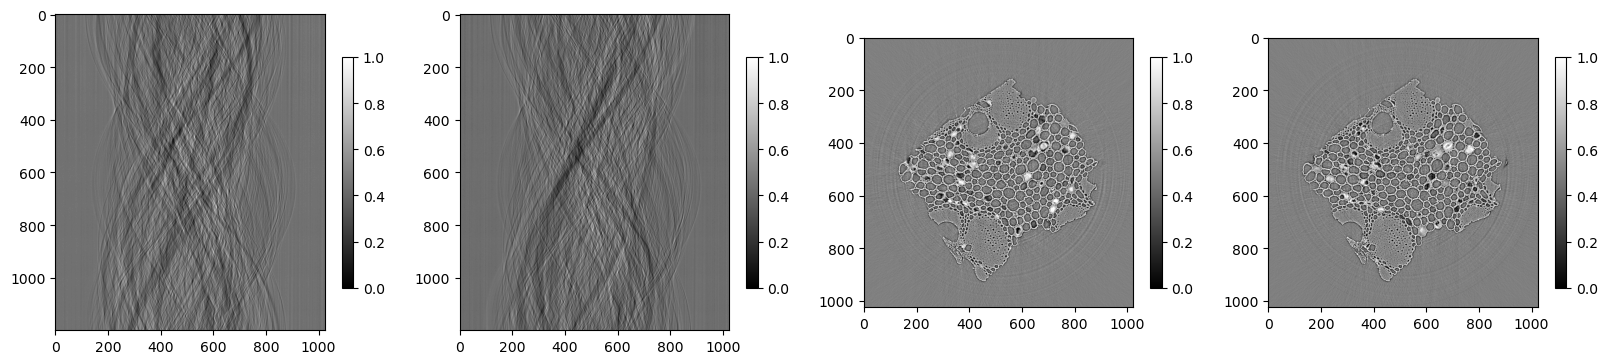

torch.Size([2, 1, 1200, 1024])
torch.Size([2, 1, 1024, 1024])


In [4]:
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,4,figsize=(20, 6))
for i in range(2):
  cbar = fig.colorbar(ax[i].imshow(example_data[i][0].cpu(),cmap='gray'), ax=ax[i], orientation='vertical', extend='neither',shrink=0.5)
  cbar = fig.colorbar(ax[i+2].imshow(example_targets[i][0].cpu(),cmap='gray'), ax=ax[i+2], orientation='vertical', extend='neither',shrink=0.5)
plt.show()
print(example_data.shape)
print(example_targets.shape)

In [5]:
model = Net(in_channel=1, scale=4,nums_projects=1200,image_size=1024)
summary(model.to('cpu'), (1, 1200, 1024), batch_size=2, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [2, 1200, 65536]      67,108,864
            Conv2d-2           [2, 1, 256, 256]           1,201
            Conv2d-3          [2, 16, 256, 256]             160
       BatchNorm2d-4          [2, 16, 256, 256]              32
             PReLU-5          [2, 16, 256, 256]               1
            Unfold-6             [2, 144, 7396]               0
            Conv2d-7            [2, 72, 86, 86]          10,440
       BatchNorm2d-8            [2, 72, 86, 86]             144
             PReLU-9            [2, 72, 86, 86]               1
           Conv2d-10            [2, 72, 86, 86]          93,384
      BatchNorm2d-11            [2, 72, 86, 86]             144
            PReLU-12            [2, 72, 86, 86]               1
           Conv2d-13            [2, 72, 86, 86]          93,384
      BatchNorm2d-14            [2, 72,

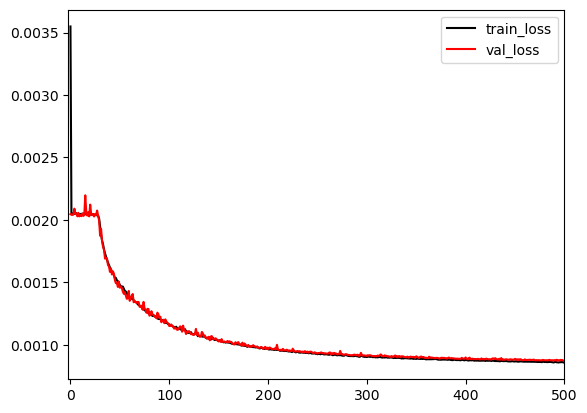

100%|██████████| 500/500 [299:20:01<00:00, 2155.20s/it]


In [ ]:
loss_fun = torch.nn.MSELoss()
early_stopping=EarlyStopping(patience=35, verbose=True,delta=0.0000001, path='/home/zhengmao/hbtask/reconstruct/checkpoints/checkpoints_bamboo')
optimizer = torch.optim.Adam(lr=args.init_lr, params=model.parameters())
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, 
                  threshold=0.0000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
result = train(train_dataloader, valid_dataloader, model, loss_fun, optimizer, scheduler, args.epochs, args.device,early_stopping,patch_size=args.patch_size)

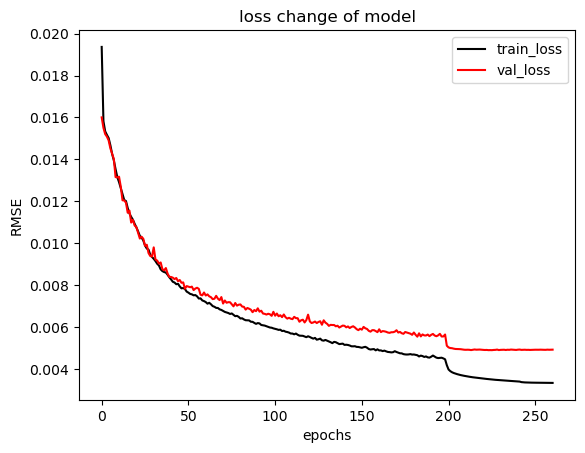

In [13]:
plt.cla()
plt.plot(result.train_losslist, color='black',label='train_loss')
plt.plot(result.val_losslist, color='red',label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel("RMSE")
plt.title('loss change of model')
display.clear_output(wait=True)
plt.pause(0.00000001)

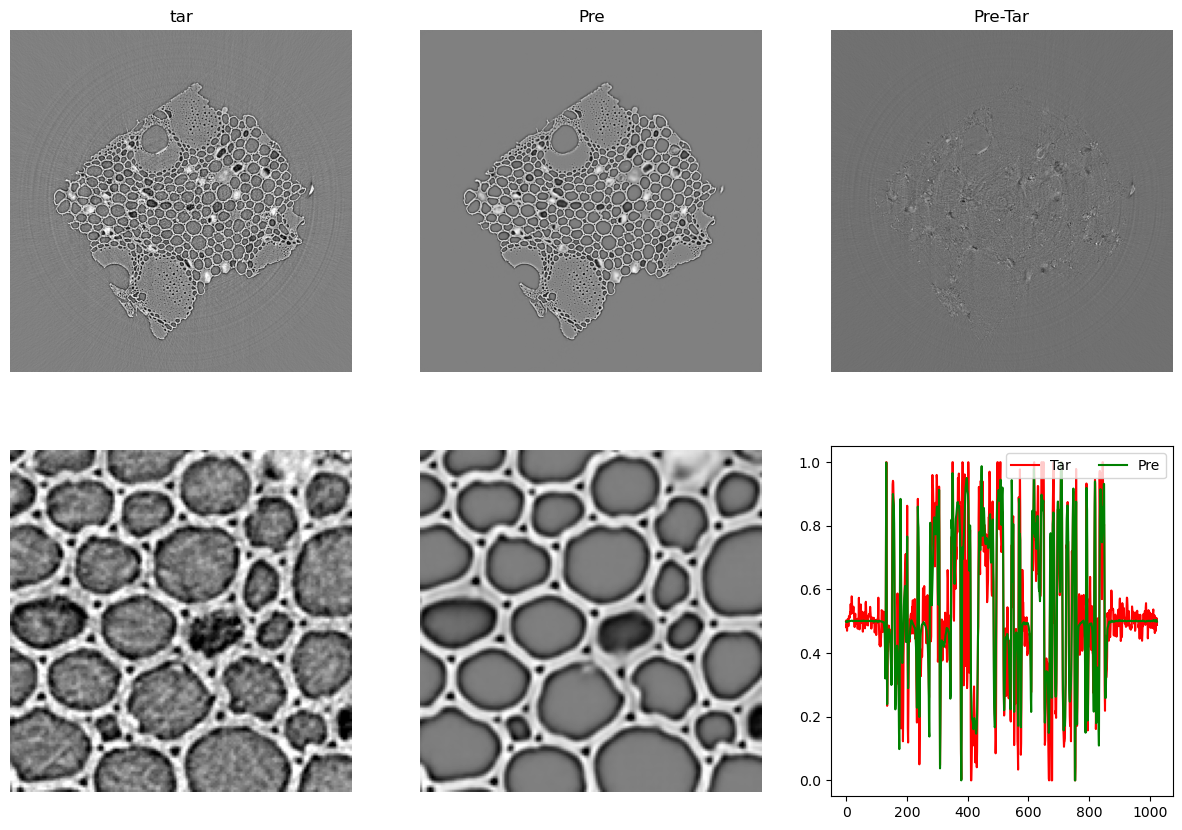

Rmse: 0.05487995382362337 PSNR: 25.23080316391363 SSIM: 0.8438355992643277 MSE: 0.00302844 MS_SSIM: 0.86854196 m-time 0.5287923216819763


In [6]:
model1 = Net(in_channel=1,scale=4,nums_projects=1200,image_size=1024).to(args.device)
parm=torch.load('/home/zhengmao/hbtask/SHARP/checkpoints/checkpoints_bamboo.pth')
model1.load_state_dict(parm)
test(args,valid_dataloader,model1.to(args.device),num_projections=1200)